# Semeval 2025 Task 10
### Subtask 1: Entity Framing

Given a news article and a list of mentions of named entities (NEs) in the article, assign for each such mention one or more roles using a predefined taxonomy of fine-grained roles covering three main type of roles: protagonists, antagonists, and innocent. This is a multi-label multi-class text-span classification task.

## 1. Importing libraries

In [1]:
# Instructor compatible with these versions only
!pip install -q huggingface_hub==0.23.5
!pip install -q langchain==0.1.2 sentence_transformers==2.2.2

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
import seaborn as sns
import os


In [3]:
!pip install InstructorEmbedding

## 2. Reading our data


We will go ahead and start by reading the annotations from the subtask-1.

* The annotations are our ground-truths.
For each article we read it's id, it's entity which is by-default given to us, and the class/sub-class where it belongs to.

In [4]:
raw_annotation_data = []

with open("data/semeval_data/subtask-1-annotations.txt", 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        raw_annotation_data.append(parts)

annotations_df = pd.DataFrame(raw_annotation_data)

In [5]:
annotations_df.head()

,0,1,2,3,4,5,6
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,Spy,None
1,EN_UA_103861.txt,China,1516,1520,Antagonist,Instigator,None
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,Terrorist,None
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,Peacemaker,Guardian
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,Incompetent,None


In [6]:
annotations_df.shape

(414, 7)

For simplicity, we will ignore the `fine-grained_roles` attribute for, as it requires further thinking on how to handle a specific article on having multiple roles.

For now, we will focus on trying to classify each entity on it's `main_role` and then move from there.

We will also rename our labels to represent the actual ones:

In [7]:
annotations_df.rename(columns={0: 'article_id', 1: 'entity_mention', 2: 'start_offset',
                   3: 'end_offset', 4: 'main_role', 5: 'fine_grained_roles',
                   6: 'additional_info'}, inplace=True)

annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,fine_grained_roles,additional_info
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,Spy,None
1,EN_UA_103861.txt,China,1516,1520,Antagonist,Instigator,None
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,Terrorist,None
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,Peacemaker,Guardian
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,Incompetent,None


Notice that in a single article, we can have the same entity mentioned playing different roles:

In [8]:
annotations_df[annotations_df['article_id'] == 'EN_UA_013257.txt']

,article_id,entity_mention,start_offset,end_offset,main_role,fine_grained_roles,additional_info
398,EN_UA_013257.txt,Russia,375,380,Protagonist,Underdog,None
399,EN_UA_013257.txt,Russia,944,949,Innocent,Victim,None
400,EN_UA_013257.txt,Russia,1590,1595,Protagonist,Guardian,None
401,EN_UA_013257.txt,Western countries,1667,1683,Antagonist,Saboteur,None
402,EN_UA_013257.txt,Russia,1763,1768,Protagonist,Virtuous,None


In [9]:
# To be changed, for simplity now
annotations_df.drop(columns=['fine_grained_roles', 'additional_info'], inplace=True)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role
0,EN_UA_103861.txt,Chinese,791,797,Antagonist
1,EN_UA_103861.txt,China,1516,1520,Antagonist
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist
4,EN_UA_021270.txt,Yermak,667,672,Antagonist


Also, notice that in the `article_id` the beginning of it, the `EN_*` part, is irrelevant to us.

We will go ahead and remove it and only keep the id of the article which is the part we actually want.

In [10]:
def extract_article_id(filename):
    number_part = filename.split('_')[-1].split('.')[0]
    return number_part

print(extract_article_id('EN_UA_103861.txt'))

103861


In [11]:
annotations_df['article_id'] = annotations_df['article_id'].apply(extract_article_id)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role
0,103861,Chinese,791,797,Antagonist
1,103861,China,1516,1520,Antagonist
2,103861,Hamas,2121,2125,Antagonist
3,103861,Donald Trump,4909,4920,Protagonist
4,021270,Yermak,667,672,Antagonist


We will know read our actual articles.

In [12]:
def read_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()


We create a placeholder dataframe, that is going to be filled up.

There are 2 columns that we are seeking, the `article_id` and the actual `content` of that.

In [13]:
documents_df = pd.DataFrame(columns=['article_id', 'content'])

In [14]:
folder_path = "data/semeval_data/raw-documents"

for filename in os.listdir(folder_path):
    if filename.endswith('.txt') and filename.startswith('EN'):
        article_id = extract_article_id(filename)
        file_path = os.path.join(folder_path, filename)
        content = read_file_content(file_path)

        new_row = pd.DataFrame({'article_id': [article_id], 'content': [content]})

        documents_df = pd.concat([documents_df, new_row], ignore_index=True)

documents_df.head()

,article_id,content
0,104876,Putin honours army unit blamed for Bucha massa...
1,023211,Europe Putin thanks US journalist Tucker Carls...
2,011260,Russia has a clear plan to resolve the conflic...
3,101067,"First war of TikTok era sees tragedy, humor an..."
4,102963,Ukraine's President Zelenskyy to address Mexic...


There are 200 articles that are given to us for this task:

In [15]:
documents_df.shape

(200, 2)

We then merge our dataframes into a single dataframe constisting.

The derived dataframe has the following columns:

* `article_id`
* `content`
* `entity_mention`
* The entity's starting and ending position in the article
* The ground truth of the entity.

In [16]:
dataset = pd.merge(documents_df, annotations_df, on='article_id')
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist


In [17]:
print(dataset.iloc[4].content)

Russia has a clear plan to resolve the conflict in Ukraine 

 The conflict in Ukraine may end either by diplomatic or military means. However, it can be possible only after Moscow achieves its goals.

"An opportunity to resolve the conflict will appear only when Ukraine ceases to pose a threat to Russia and discriminate against Russian-speaking Ukrainians,” Vasily Nebenzya, Russia's Ambassador to the UN Security Council, said at a briefing at the UN Security Council.

"If this result can be achieved through negotiations, we are ready for such a scenario. If not, then our objectives will be achieved by military means," he added.

Russia is not fighting against the Ukrainian people. Russia is fighting against the criminal nationalist regime that came to power in 2014” after the coup in Kyiv, the diplomat said.

"The new Ukrainian leadership is trying to purge the country of everything connected with Russia and glorify Nazi accomplices. <…>

"The Kyiv regime and its most rabid patrons hav

Since the annotations where limited to `417`, we also expect that the merged dataframe will be of that size:

In [18]:
dataset.shape

(417, 6)

We also do a sanity-check to see if there are any missing values:

In [19]:
dataset.isnull().sum()

article_id        0
content           0
entity_mention    0
start_offset      0
end_offset        0
main_role         0
dtype: int64

Notice that the distributions of roles are uneven, with the `Antagonist` being the most common class, and `Innocent` being the least common.

This should worry us, and we should keep this in mind when attempting to find a good classifier.

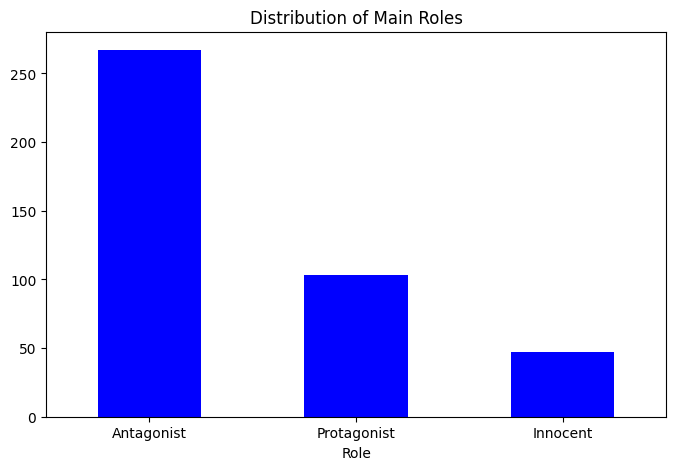

In [20]:
role_counts = dataset['main_role'].value_counts()

plt.figure(figsize=(8, 5))
role_counts.plot(kind='bar', color=['blue'])
plt.title('Distribution of Main Roles')
plt.xlabel('Role')
plt.xticks(rotation=0)
plt.show()

## 3. Preparing our data

We now begin by processing our data and preparing it in order to find a good, initial/baseline classifier for this task.


Our goal is to classify those entities into 3 classes:
* `Protagonist`
* `Antagonist`
* `Innocent`

It's obvious that this task is an instance of a supervised learning, we have some features and we are also given the ground truth, the class where each entity truly belongs to.

We begin by shuffling our data:

In [21]:
random_state = 42 # used for experimentantions
# dataset = dataset.sample(frac=1, random_state=random_state)
dataset = dataset.sample(frac=1)
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role
77,103517,Evan Gershkovich has jail appeal in Russia blo...,Gershkovich,636,646,Protagonist
270,019640,"After North Korea’s Kim Jong Un, Putin and Xi ...",Russia,435,440,Protagonist
104,002531,Kyiv's Mayor Says He's 'Ready to Fight' as Rus...,Mayor Ivan Fedorov,1346,1363,Innocent
151,004209,"Russia threatens nukes for US, UK, Finland if ...",Minister Alexander Grushko,3053,3078,Protagonist
122,013617,Filling the Blank Spots in Our National Histor...,American Secretary of State Madeleine Albright,1400,1445,Antagonist


In [22]:
print(dataset.iloc[1].content)

After North Korea’s Kim Jong Un, Putin and Xi to meet in Beijing in October, says Kremlin 

 Russian President Vladimir Putin will meet China’s Xi Jinping for talks in Beijing in October, the Kremlin said on Tuesday, Putin’s first known trip abroad since an arrest warrant was issued against him over the deportation of children from Ukraine.

Nikolai Patrushev, a close Putin ally and the secretary of Russia’s Security Council, said Russia and China should deepen cooperation in the face of the West’s attempt to contain them both.

He was quoted by the Interfax news agency as saying that the talks in Beijing would be “thorough”, at a meeting in Moscow with China’s top diplomat, Wang Yi.

Putin will attend the third Belt and Road Forum after an invitation by Xi during a high-profile visit to Moscow in March.

Days before that visit, the International Criminal Court (ICC) issued a warrant for Putin’s arrest on suspicion of illegally deporting hundreds of children or more from Ukraine.

Mosc

### 3.1 Training a baseline model

We will begin by seeing how good of a job traditional machine learning models can do for this kind of tasks.

Our idea is simple, since we have the `start_offset` and `end_offset` of each entity, we can also get the nearby x words of that entity surrounding it, before and after:

In [23]:
def get_context(row, window=180):
    content = row['content']
    start = int(row['start_offset'])
    end = int(row['end_offset'])

    words = content.split()

    pre_entity_text = content[:start].split()
    post_entity_text = content[end + 1:].split()

    # Get context words before and after
    context_before = " ".join(pre_entity_text[-window:])
    context_after = " ".join(post_entity_text[:window])

    return context_before, context_after

dataset['context_before'], dataset['context_after'] = zip(*dataset.apply(get_context, axis=1))

In [24]:
example_context = "Moscow: Russia will ask the UN Security Council for an investigation"
entity_mention = "Russia"
start_offset = 8
end_offset = 13

example_df = pd.DataFrame({
    'content': [example_context],
    'entity_mention': [entity_mention],
    'start_offset': [start_offset],
    'end_offset': [end_offset]
})

example_df

,content,entity_mention,start_offset,end_offset
0,Moscow: Russia will ask the UN Security Counci...,Russia,8,13


In [25]:
get_context(example_df.iloc[0])

('Moscow:', 'will ask the UN Security Council for an investigation')

The article in row 1, has the entity mentioned:

In [26]:
dataset.iloc[1].entity_mention

'Russia'

Context before the entity:

In [27]:
dataset.iloc[1].context_before

'After North Korea’s Kim Jong Un, Putin and Xi to meet in Beijing in October, says Kremlin Russian President Vladimir Putin will meet China’s Xi Jinping for talks in Beijing in October, the Kremlin said on Tuesday, Putin’s first known trip abroad since an arrest warrant was issued against him over the deportation of children from Ukraine. Nikolai Patrushev, a close Putin ally and the secretary of Russia’s Security Council, said'

Context after the entity:

In [28]:
dataset.iloc[1].context_after

'and China should deepen cooperation in the face of the West’s attempt to contain them both. He was quoted by the Interfax news agency as saying that the talks in Beijing would be “thorough”, at a meeting in Moscow with China’s top diplomat, Wang Yi. Putin will attend the third Belt and Road Forum after an invitation by Xi during a high-profile visit to Moscow in March. Days before that visit, the International Criminal Court (ICC) issued a warrant for Putin’s arrest on suspicion of illegally deporting hundreds of children or more from Ukraine. Moscow denies the allegations and the Kremlin said the warrant was evidence of the West’s hostility to Russia, which opened a criminal case against the ICC prosecutor and the judges who issued the warrant. Russia’s full-scale invasion of Ukraine early last year has triggered one of the deadliest European conflicts since World War Two and the biggest confrontation between Moscow and the West since the 1962 Cuban Missile Crisis. Putin has pivoted 

In [29]:
dataset.iloc[1].main_role

'Protagonist'

We also do again a sanity check that our results are correct:

In [30]:
dataset.iloc[1].content

'After North Korea’s Kim Jong Un, Putin and Xi to meet in Beijing in October, says Kremlin \n\n Russian President Vladimir Putin will meet China’s Xi Jinping for talks in Beijing in October, the Kremlin said on Tuesday, Putin’s first known trip abroad since an arrest warrant was issued against him over the deportation of children from Ukraine.\n\nNikolai Patrushev, a close Putin ally and the secretary of Russia’s Security Council, said Russia and China should deepen cooperation in the face of the West’s attempt to contain them both.\n\nHe was quoted by the Interfax news agency as saying that the talks in Beijing would be “thorough”, at a meeting in Moscow with China’s top diplomat, Wang Yi.\n\nPutin will attend the third Belt and Road Forum after an invitation by Xi during a high-profile visit to Moscow in March.\n\nDays before that visit, the International Criminal Court (ICC) issued a warrant for Putin’s arrest on suspicion of illegally deporting hundreds of children or more from Ukr

We then combine the ccontext before and after the entity to a single, `entity_context`.

In [31]:
dataset['entity_context'] = dataset['context_before'] + " " + dataset['entity_mention'] + " " + dataset['context_after']

In [32]:
dataset.iloc[1].entity_context

'After North Korea’s Kim Jong Un, Putin and Xi to meet in Beijing in October, says Kremlin Russian President Vladimir Putin will meet China’s Xi Jinping for talks in Beijing in October, the Kremlin said on Tuesday, Putin’s first known trip abroad since an arrest warrant was issued against him over the deportation of children from Ukraine. Nikolai Patrushev, a close Putin ally and the secretary of Russia’s Security Council, said Russia and China should deepen cooperation in the face of the West’s attempt to contain them both. He was quoted by the Interfax news agency as saying that the talks in Beijing would be “thorough”, at a meeting in Moscow with China’s top diplomat, Wang Yi. Putin will attend the third Belt and Road Forum after an invitation by Xi during a high-profile visit to Moscow in March. Days before that visit, the International Criminal Court (ICC) issued a warrant for Putin’s arrest on suspicion of illegally deporting hundreds of children or more from Ukraine. Moscow deni

In [33]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,context_before,context_after,entity_context
77,103517,Evan Gershkovich has jail appeal in Russia blo...,Gershkovich,636,646,Protagonist,Evan Gershkovich has jail appeal in Russia blo...,bravely smiled from behind the defendant's gla...,Evan Gershkovich has jail appeal in Russia blo...
270,019640,"After North Korea’s Kim Jong Un, Putin and Xi ...",Russia,435,440,Protagonist,"After North Korea’s Kim Jong Un, Putin and Xi ...",and China should deepen cooperation in the fac...,"After North Korea’s Kim Jong Un, Putin and Xi ..."
104,002531,Kyiv's Mayor Says He's 'Ready to Fight' as Rus...,Mayor Ivan Fedorov,1346,1363,Innocent,accused Russian forces of capturing mayors in ...,was captured two days earlier. Russia went on ...,accused Russian forces of capturing mayors in ...
151,004209,"Russia threatens nukes for US, UK, Finland if ...",Minister Alexander Grushko,3053,3078,Protagonist,with The Mirror. “The Finns in general should ...,said Russia knows that NATO wants to “militari...,with The Mirror. “The Finns in general should ...
122,013617,Filling the Blank Spots in Our National Histor...,American Secretary of State Madeleine Albright,1400,1445,Antagonist,his famous “Kitchen debate” with Soviet leader...,", who had famously declared in 1996 that the d...",his famous “Kitchen debate” with Soviet leader...


In [34]:
!pip install emoji

In [35]:
import spacy
import re
import emoji

nlp = spacy.load("en_core_web_sm")

def clean_article(article_text):
    # Remove URLs
    article_text = re.sub(r'http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.com', '', article_text, flags=re.MULTILINE)

    doc = nlp(article_text)
    cleaned_tokens = []

    for token in doc:
        if (token.is_space or '@' in token.text or emoji.is_emoji(token.text)):
            continue

        cleaned_tokens.append(token.text + token.whitespace_)

    cleaned_article = "".join(cleaned_tokens).strip()

    return cleaned_article

In [36]:
dataset['entity_context'] = dataset['entity_context'].apply(clean_article)
dataset.iloc[3].entity_context

'with The Mirror. “The Finns in general should be grateful to Russia for their statehood, for the fact that Finland exists as a country.” “If the United States threatens our state, it’s good: here is the Sarmat [Satan-2] for you, and there will be nuclear ashes from you if you think that Russia should not exist,” he continued. “And Finland says that it is at one with the USA. Well, get in line.” The Satan-2 is a ballistic missile capable of carrying 10 to 15 nuclear warheads, with an estimated destructive power of three megatons each. Russia wouldn’t need to move nukes to its European border to carry out its threat, officials boasted. “We can hit with a Sarmat [known in the West as Satan-2] from Siberia, and even reach the UK,” he said. “And if we strike from Kaliningrad … the hypersonic’s reaching time is 200 seconds – so go ahead, guys. “On the Finnish border we will have not strategic weapons, but Kinzhal-class, one that will reach Finland in 20 seconds, or even 10 seconds.” Separat

In [37]:
dataset.iloc[1].entity_context

'After North Korea’s Kim Jong Un, Putin and Xi to meet in Beijing in October, says Kremlin Russian President Vladimir Putin will meet China’s Xi Jinping for talks in Beijing in October, the Kremlin said on Tuesday, Putin’s first known trip abroad since an arrest warrant was issued against him over the deportation of children from Ukraine. Nikolai Patrushev, a close Putin ally and the secretary of Russia’s Security Council, said Russia and China should deepen cooperation in the face of the West’s attempt to contain them both. He was quoted by the Interfax news agency as saying that the talks in Beijing would be “thorough”, at a meeting in Moscow with China’s top diplomat, Wang Yi. Putin will attend the third Belt and Road Forum after an invitation by Xi during a high-profile visit to Moscow in March. Days before that visit, the International Criminal Court (ICC) issued a warrant for Putin’s arrest on suspicion of illegally deporting hundreds of children or more from Ukraine. Moscow deni

In [38]:
dataset.iloc[3]

article_id                                                   004209
content           Russia threatens nukes for US, UK, Finland if ...
entity_mention                           Minister Alexander Grushko
start_offset                                                   3053
end_offset                                                     3078
main_role                                               Protagonist
context_before    with The Mirror. “The Finns in general should ...
context_after     said Russia knows that NATO wants to “militari...
entity_context    with The Mirror. “The Finns in general should ...
Name: 151, dtype: object

In [39]:
dataset['entity_context'].iloc[4]

'his famous “Kitchen debate” with Soviet leader Nikita Khruschev. Nixon favorably compared the standard of living of American suburbanites to that of their Russian counterparts under Communism. Criticizing Soviet society was a serious crime in those days, but I doubt that the Russians ever considered arresting Nixon and giving him a ten year stretch in the gulag for “anti-Soviet agitation.” Not even Maoist China at the height of its Cultural Revolution would have considered such a thing. TRUTH LIVES on at But late last week, on the eve of a Russia-China leadership summit in Moscow, Europe’s International Criminal Court (ICC) in the Hague issued an arrest warrant for Russian President Vladimir Putin, the man who controls the world’s largest nuclear arsenal, whose striking power is further enhanced by its revolutionary hypersonic delivery systems. The charges against Putin were that he had ordered the humanitarian evacuation of children from the dangerous Ukraine warzone, and the ICC als

In [40]:
dataset['main_role'].iloc[4]

'Antagonist'

In [41]:
dataset['entity_mention'].iloc[4]

'American Secretary of State Madeleine Albright'

In [42]:
from sklearn.preprocessing import LabelEncoder

_le = LabelEncoder()
dataset['main_role_encoded'] = _le.fit_transform(dataset['main_role'])

In [43]:
dataset['main_role_encoded']

77     2
270    2
104    1
151    2
122    0
      ..
251    2
20     0
197    1
279    0
161    0
Name: main_role_encoded, Length: 417, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_temp = train_test_split(dataset, train_size=0.85, shuffle=True, stratify=dataset['main_role_encoded'])

In [45]:
dataset_val, dataset_test = train_test_split(dataset_temp, train_size=0.5, shuffle=True, stratify=dataset_temp['main_role_encoded'])

In [46]:
dataset_test.main_role.value_counts()

main_role
Antagonist     20
Protagonist     8
Innocent        4
Name: count, dtype: int64

In [47]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

def get_classification_report(y_true, y_pred):
  # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return conf_matrix

In [48]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, x, y_true):
  y_pred = model.predict(x)
  classification_report_df = get_classification_report(y_true, y_pred)
  print(classification_report_df)
  print('\n')
  conf = plot_confusion_matrix(y_true, y_pred)
  return conf

def get_cross_val_score(model, x, y, scoring='f1_macro', splits=3):
  cv = StratifiedKFold(n_splits=splits, shuffle=True)
  cross_val_scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
  print(f"Cross-validation scores: {cross_val_scores}")
  print(f"Mean CV F1 Score: {cross_val_scores.mean()}")

In [49]:
import os

def embeddings_exist(embeddings_path):
    embeddings_files = [
        'train_embeddings.npy',
        'val_embeddings.npy',
        'test_embeddings.npy',
    ]
    # Check if all required embedding files exist
    for embedding_file in embeddings_files:
        path = os.path.join(embeddings_path, embedding_file) 
        if not os.path.exists(path):
            return False
    return True

In [50]:
model = None
embeddings_dir = 'data/embeddings/entity_framing/'

if not embeddings_exist(embeddings_dir):
    from InstructorEmbedding import INSTRUCTOR
    model = INSTRUCTOR('hkunlp/instructor-large')
else:
    print("Skipping loading model")

Skipping loading model


In [51]:
print(model)

None


In [52]:
def get_instructor_embeddings(dataset):
    embeddings = []
    for index, row in dataset.iterrows():
        entity = row['entity_mention']
        context = row['entity_context']
        instruction = (
            f"Classify the role of {entity} in this context as antagonist, protagonist, or innocent. Focus on their "
            f"actions, intent, and surrounding sentiment: "
        )
        embedding = model.encode([[instruction, context]])
        embeddings.append(embedding[0])

    return np.array(embeddings)

In [53]:
train_embeddings_path = os.path.join(embeddings_dir, 'train_embeddings.npy')
val_embeddings_path = os.path.join(embeddings_dir, 'val_embeddings.npy')
test_embeddings_path = os.path.join(embeddings_dir, 'test_embeddings.npy')

def load_embeddings(file_path):
  if os.path.exists(file_path):
      print(f"Loading embeddings from {file_path}")
      return np.load(file_path)
  else:
      print(f"No embeddings found at {file_path}")
      return None

def save_embeddings(embeddings, file_path):
    np.save(file_path, embeddings)
    print(f"Embeddings saved to {file_path}")

def ensure_embeddings(dataset, dataset_type='train'):
    if dataset_type == 'train':
        embeddings_path = train_embeddings_path
    elif dataset_type == 'val':
        embeddings_path = val_embeddings_path
    elif dataset_type == 'test':
        embeddings_path = test_embeddings_path
    else:
        print('Dataset type must be either train, val or test')
        return

    embeddings = load_embeddings(embeddings_path)

    if embeddings is None:
        print(f"Generating {dataset_type} embeddings...")
        embeddings = get_instructor_embeddings(dataset)
        save_embeddings(embeddings, embeddings_path)

    return embeddings

In [54]:
train_x_embeddings = ensure_embeddings(dataset_train, dataset_type='train')
val_x_embeddings = ensure_embeddings(dataset_val, dataset_type='val')

Loading embeddings from data/embeddings/entity_framing/train_embeddings.npy
Loading embeddings from data/embeddings/entity_framing/val_embeddings.npy


In [55]:
train_x_embeddings.shape

(354, 768)

In [56]:
train_x_embeddings[0][:20]

array([-0.05841691,  0.01112601, -0.03256173,  0.03402437,  0.05308804,
        0.00099195,  0.0074056 ,  0.02002816, -0.01926138,  0.05096211,
        0.04431849, -0.00706494, -0.00746014,  0.03274738, -0.02461849,
       -0.04025342, -0.03452646,  0.0340739 , -0.04446978, -0.00689082],
      dtype=float32)

In [57]:
train_x_embeddings[1][:20]

array([-0.02897515,  0.02511702, -0.03397759, -0.00836888,  0.07044836,
        0.0201686 , -0.0080524 , -0.01178747, -0.01934532,  0.03242737,
        0.0587171 ,  0.01234543,  0.04597619,  0.01621855, -0.01098715,
       -0.02332655, -0.02460176, -0.00770775, -0.04632996,  0.02161702],
      dtype=float32)

In [58]:
train_y_encoded = dataset_train['main_role_encoded'].reset_index(drop=True)
val_y_encoded = dataset_val['main_role_encoded'].reset_index(drop=True)

train_y_encoded

0      0
1      0
2      0
3      0
4      0
      ..
349    0
350    1
351    0
352    0
353    0
Name: main_role_encoded, Length: 354, dtype: int64

In [59]:
test_y_embeddings = ensure_embeddings(dataset_test, dataset_type='test')
test_y_encoded = dataset_test['main_role_encoded'].reset_index(drop=True)

Loading embeddings from data/embeddings/entity_framing/test_embeddings.npy


In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
get_cross_val_score(knn_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.34966794 0.25641026 0.36255144]
Mean CV F1 Score: 0.32287654563869395


              precision    recall  f1-score    support
0              0.608696  0.700000  0.651163  20.000000
1              0.250000  0.333333  0.285714   3.000000
2              0.250000  0.125000  0.166667   8.000000
accuracy       0.516129  0.516129  0.516129   0.516129
macro avg      0.369565  0.386111  0.367848  31.000000
weighted avg   0.481417  0.516129  0.490766  31.000000




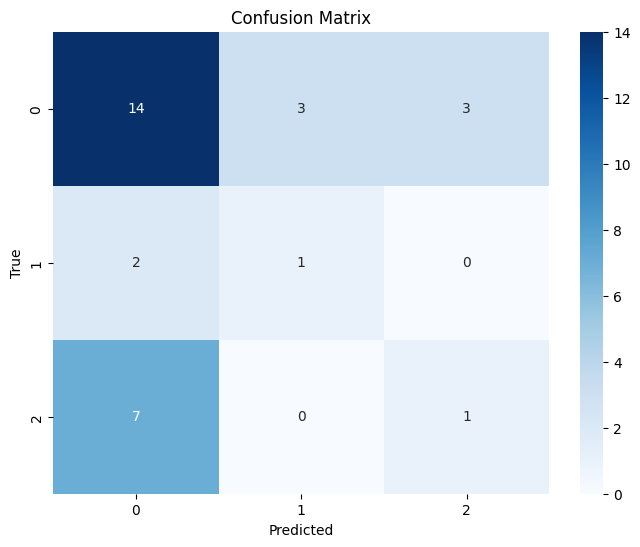

array([[14,  3,  3],
       [ 2,  1,  0],
       [ 7,  0,  1]])

In [61]:
knn_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(knn_classifier, val_x_embeddings, val_y_encoded)

In [62]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=150)
get_cross_val_score(xgb_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.26619048 0.3210077  0.33022098]
Mean CV F1 Score: 0.30580638315932435


              precision    recall  f1-score    support
0              0.640000  0.800000  0.711111  20.000000
1              0.333333  0.333333  0.333333   3.000000
2              0.333333  0.125000  0.181818   8.000000
accuracy       0.580645  0.580645  0.580645   0.580645
macro avg      0.435556  0.419444  0.408754  31.000000
weighted avg   0.531183  0.580645  0.537960  31.000000




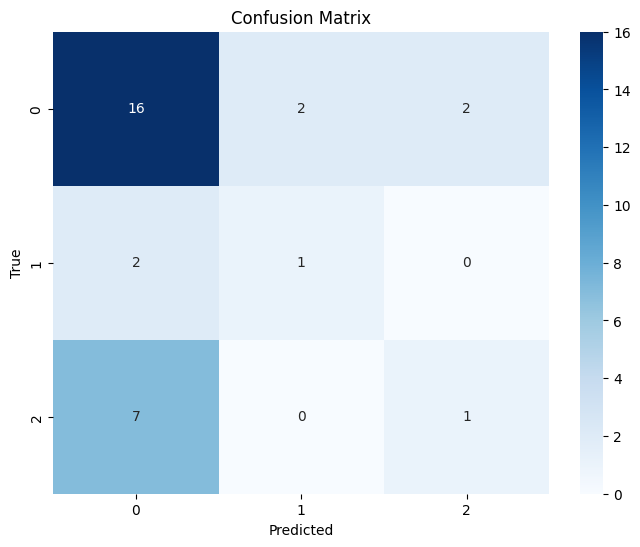

array([[16,  2,  2],
       [ 2,  1,  0],
       [ 7,  0,  1]])

In [63]:
xgb_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(xgb_classifier, val_x_embeddings, val_y_encoded)

In [64]:
label = _le.inverse_transform([1])
print(label)

['Innocent']


In [65]:
from collections import Counter
Counter(train_y_encoded)

Counter({0: 227, 2: 87, 1: 40})

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_depth=5)
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=100, learning_rate=.1)

get_cross_val_score(adaboost_classifier, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-validation scores: [0.36374269 0.30475764 0.34911296]
Mean CV F1 Score: 0.33920442982834303


In [67]:
adaboost_classifier.fit(train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=100)

              precision    recall  f1-score    support
0              0.680000  0.850000  0.755556  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              0.750000  0.375000  0.500000   8.000000
accuracy       0.645161  0.645161  0.645161   0.645161
macro avg      0.476667  0.408333  0.418519  31.000000
weighted avg   0.632258  0.645161  0.616487  31.000000




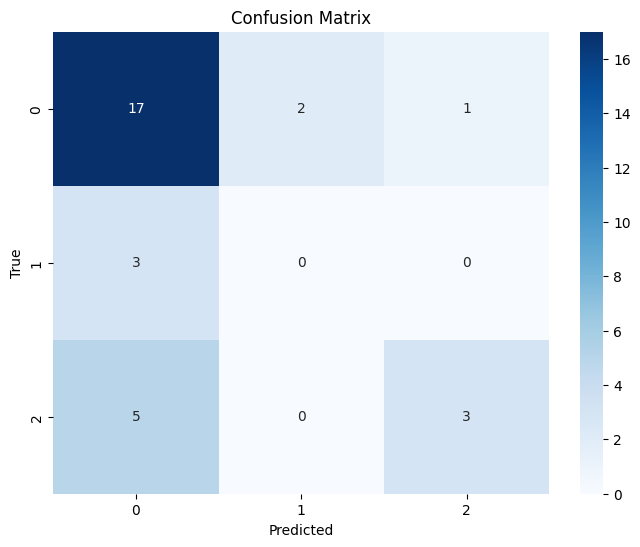

array([[17,  2,  1],
       [ 3,  0,  0],
       [ 5,  0,  3]])

In [68]:
evaluate_model(adaboost_classifier, val_x_embeddings, val_y_encoded)

In [69]:
from sklearn.utils import class_weight

classes = np.unique(train_y_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_y_encoded)
class_weights

array([0.51982379, 2.95      , 1.35632184])

In [70]:
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 0.5198237885462555, 1: 2.95, 2: 1.3563218390804597}

In [71]:
custom_class_weights = {
    0: 0.5,  # Antagonist
    1: 3.5,  # Innocent (increased from 2.95)
    2: 1.5   # Protagonist (slightly increased)
}

In [72]:
sample_weights = np.array([custom_class_weights[label] for label in train_y_encoded])

In [73]:
sample_weights

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 3.5, 0.5, 3.5,
       0.5, 1.5, 0.5, 0.5, 0.5, 3.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5,
       1.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5,
       1.5, 1.5, 3.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5, 0.5, 1.5, 1.5,
       0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 1.5, 3.5, 1.5, 0.5, 0.5, 3.5, 0.5, 0.5, 3.5, 0.5, 0.5, 0.5,
       0.5, 3.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5,
       1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 1.5,
       0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5,
       0.5, 1.5, 0.5, 3.5, 0.5, 0.5, 0.5, 3.5, 3.5, 3.5, 0.5, 3.5, 0.5,
       0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 3.5, 1.5, 0.5, 1.5, 0.5,
       0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.

In [74]:
import xgboost as xgb

xgb_weighted = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150)
get_cross_val_score(xgb_weighted, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.28444126 0.28197445 0.2452381 ]
Mean CV F1 Score: 0.27055126847962596


              precision    recall  f1-score    support
0              0.681818  0.750000  0.714286  20.000000
1              0.333333  0.333333  0.333333   3.000000
2              0.500000  0.375000  0.428571   8.000000
accuracy       0.612903  0.612903  0.612903   0.612903
macro avg      0.505051  0.486111  0.492063  31.000000
weighted avg   0.601173  0.612903  0.603687  31.000000




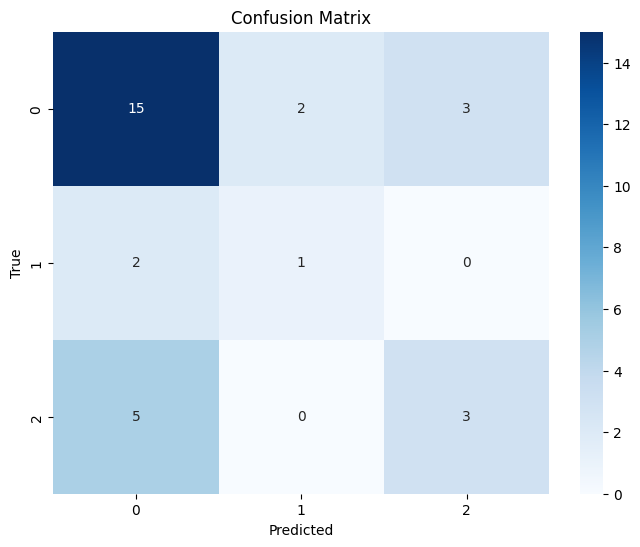

array([[15,  2,  3],
       [ 2,  1,  0],
       [ 5,  0,  3]])

In [75]:
xgb_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)
evaluate_model(xgb_weighted, val_x_embeddings, val_y_encoded)

In [76]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

decision_tree_weighted = DecisionTreeClassifier(max_depth=5, class_weight=custom_class_weights)
adaboost_weighted = AdaBoostClassifier(estimator=decision_tree_weighted, n_estimators=150, learning_rate=.1)
get_cross_val_score(adaboost_weighted, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-validation scores: [0.37378405 0.31075782 0.3028305 ]
Mean CV F1 Score: 0.32912412436689414


In [77]:
adaboost_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                  1: 3.5,
                                                                  2: 1.5},
                                                    max_depth=5),
                   learning_rate=0.1, n_estimators=150)

              precision    recall  f1-score    support
0              0.583333  0.700000  0.636364  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              0.500000  0.125000  0.200000   8.000000
accuracy       0.483871  0.483871  0.483871   0.483871
macro avg      0.361111  0.275000  0.278788  31.000000
weighted avg   0.505376  0.483871  0.462170  31.000000




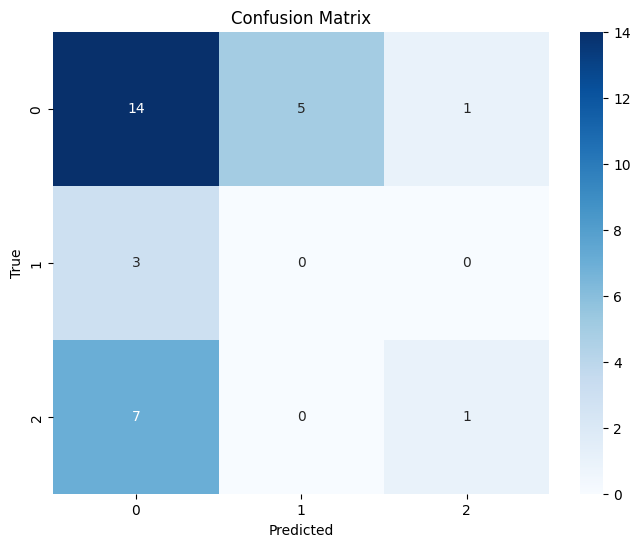

array([[14,  5,  1],
       [ 3,  0,  0],
       [ 7,  0,  1]])

In [78]:
evaluate_model(adaboost_weighted, val_x_embeddings, val_y_encoded)

In [79]:
from sklearn.svm import SVC

svm_classifier = SVC(C=10, gamma='scale', kernel='rbf') # attributes after running GridSearch
svm_classifier.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

SVC(C=10)

In [80]:
get_cross_val_score(svm_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.35029697 0.29305181 0.26436922]
Mean CV F1 Score: 0.30257266833093205


              precision    recall  f1-score    support
0              0.666667  0.500000  0.571429  20.000000
1              0.142857  0.333333  0.200000   3.000000
2              0.555556  0.625000  0.588235   8.000000
accuracy       0.516129  0.516129  0.516129   0.516129
macro avg      0.455026  0.486111  0.453221  31.000000
weighted avg   0.587302  0.516129  0.539821  31.000000




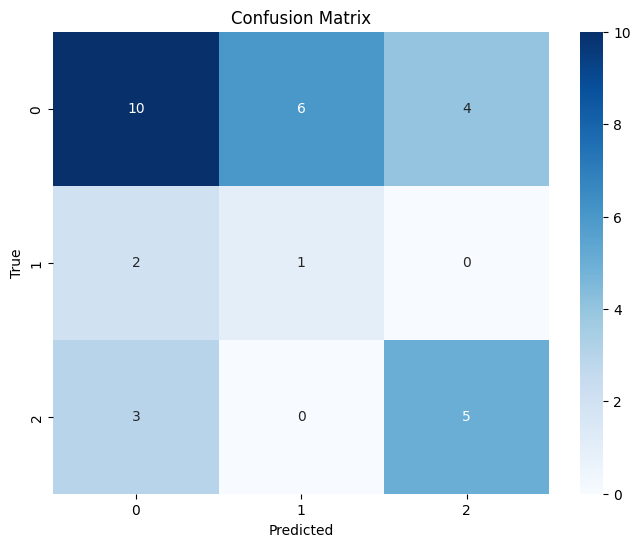

array([[10,  6,  4],
       [ 2,  1,  0],
       [ 3,  0,  5]])

In [81]:
evaluate_model(svm_classifier, val_x_embeddings, val_y_encoded)

In [82]:
classes = len(np.unique(train_y_encoded))

embedding_dim = train_x_embeddings.shape[1]

small_model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(embedding_dim,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(classes, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [83]:
def compile_and_fit(x_train, y_train, model, optimizer=None, max_epochs=100, callbacks=[], lr=0.01, use_class_weights=False):
    if not optimizer:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        epochs=max_epochs,
        validation_data=(val_x_embeddings, val_y_encoded),
        callbacks=callbacks,
        verbose=2,
        class_weight=class_weights_dict if use_class_weights else None
    )
    return history

In [84]:
def plot_history(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def evaluate_mlp(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=-1)

    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [85]:
hist_small = compile_and_fit(train_x_embeddings, train_y_encoded, small_model)

Epoch 1/100
12/12 - 0s - 24ms/step - accuracy: 0.5876 - loss: 0.9216 - val_accuracy: 0.6452 - val_loss: 0.8487
Epoch 2/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8715 - val_accuracy: 0.6452 - val_loss: 0.8587
Epoch 3/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8657 - val_accuracy: 0.6452 - val_loss: 0.8501
Epoch 4/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8574 - val_accuracy: 0.6452 - val_loss: 0.8467
Epoch 5/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8653 - val_accuracy: 0.6452 - val_loss: 0.8486
Epoch 6/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8435 - val_accuracy: 0.6452 - val_loss: 0.8544
Epoch 7/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8400 - val_accuracy: 0.6452 - val_loss: 0.8553
Epoch 8/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8337 - val_accuracy: 0.6452 - val_loss: 0.8565
Epoch 9/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8221 - val_accuracy: 0.6452 - val_loss: 0.8452
Epoch 10/

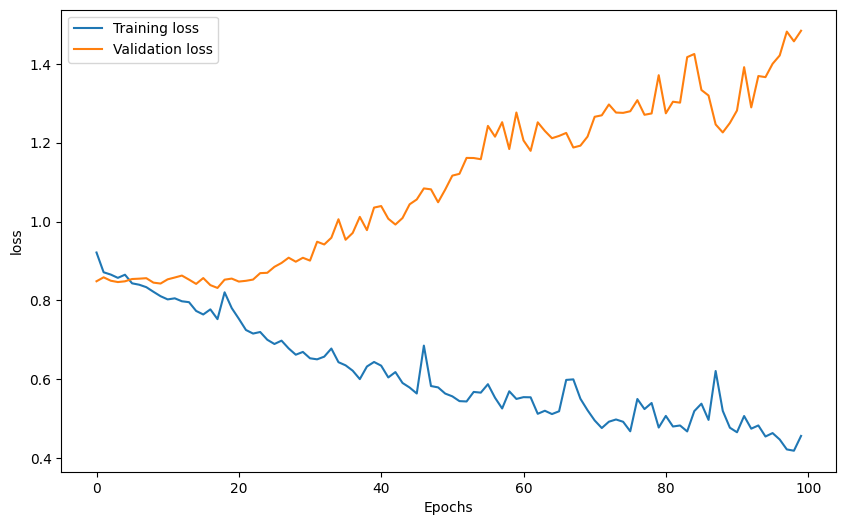

In [86]:
plot_history(hist_small)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.00      0.00      0.00         3
           2       0.50      0.25      0.33         8

    accuracy                           0.55        31
   macro avg       0.38      0.33      0.34        31
weighted avg       0.53      0.55      0.53        31

Confusion Matrix:


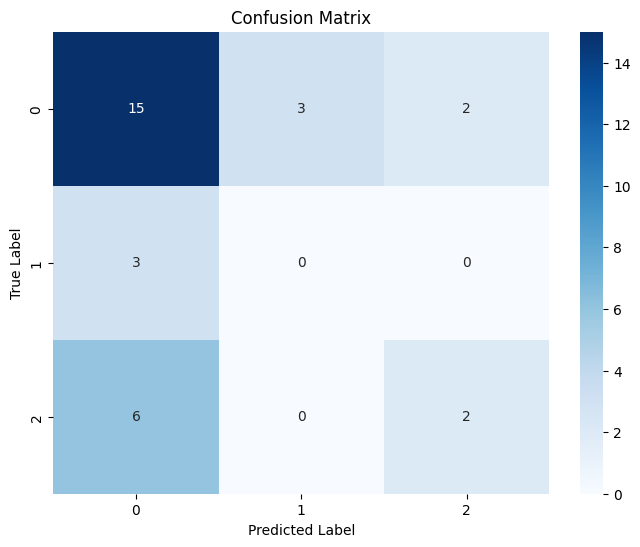

In [87]:
evaluate_mlp(small_model, val_x_embeddings, val_y_encoded)

In [88]:
import time

def pause():
    try:
      while True:
          time.sleep(60)
    except KeyboardInterrupt:
      print("Stopped")


In [89]:
# pause()